In [29]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector

import numpy as np

In [81]:
n = 3
psi = np.arange(0, (1<<n))
np.split(psi, 2)

[array([0, 1, 2, 3]), array([4, 5, 6, 7])]

In [82]:
def theta_amp (amps):
    sub_amps = np.split(amps, 2)
    norm_amps = np.linalg.norm(amps)
    if norm_amps == 0:
        return 0
    return 2*np.arccos(np.linalg.norm(sub_amps[0])/norm_amps)

In [85]:
def amp_to_ang (amps):
    n = int(np.log2(len(amps)))
    angs = [theta_amp(amps)]
    for i in range(1, n):
        sub_amps = np.split(amps, 1<<i)
        for x in sub_amps:
            angs.append(theta_amp(x))
    return angs

In [125]:
def ry_mux (n, theta, state):
    reg = QuantumRegister(n, name='x')
    circ = QuantumCircuit(reg, name='m'+r'$R_Y$'+'\n'+str(state)+'\n'+r'$\theta$'+ '='+str(np.round(theta, 2)))
    qbs = [reg[k+1] for k, x in enumerate(state) if x == '0']
    if len(qbs) != 0:
        circ.x(qbs)
    circ.p(-np.pi/2, reg[0])
    circ.h(reg[0])
    circ.mcrz(theta, reg[1:], reg[0])
    circ.h(reg[0])
    circ.p(np.pi/2, reg[0])
    if len(qbs) != 0:
        circ.x(qbs)
    return circ.to_gate()

In [105]:
def q_amp_prep (n, angs):
    reg = QuantumRegister(n, name='x')
    circ = QuantumCircuit(reg, name='amp_prep')
    circ.ry(angs[0], reg[-1])
    for i in range(1, n):
        for j in range(0, (1<<i)):
            bij = format(j, f'0{i}b')[::-1]
            circ.compose(ry_mux(i+1, angs[(1<<i)+j-1], bij), qubits=reg[-i-1:], inplace=True)
    return circ.to_gate()

9.733830449235459e-16


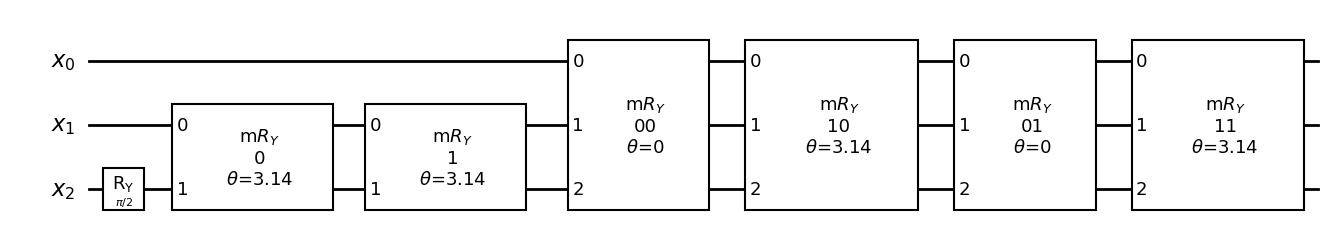

In [137]:
n = 3
psi = np.array([0, 0, 0, 1, 0, 0, 0, 1])
#psi = np.arange(1, 1+(1<<n))
psi = (1/np.linalg.norm(psi))*psi
qx = QuantumRegister(n, name='x')
qsp = QuantumCircuit(qx)
angs = amp_to_ang(psi)
qsp.compose(q_amp_prep(n, angs), inplace=True)
print(np.linalg.norm(np.array(Statevector(qsp))-psi))
qsp.decompose().draw(output='mpl', style='bw')

In [173]:
def rz_mux (n, theta, state):
    reg = QuantumRegister(n, name='x')
    anc = AncillaRegister(1, name='a')
    circ = QuantumCircuit(reg, anc, name='m'+r'$R_Z$'+'\n'+str(state)+'\n'+r'$\theta$'+ '='+str(np.round(theta, 2)))
    qbs = [reg[k] for k, x in enumerate(state) if x == '0']
    if len(qbs) != 0:
        circ.x(qbs)
    circ.mcrz(2*theta, reg, anc[0])
    if len(qbs) != 0:
        circ.x(qbs)
    return circ.to_gate()

In [174]:
def q_arg_prep (n, args):
    reg = QuantumRegister(n, name='x')
    anc = AncillaRegister(1, name='a')
    circ = QuantumCircuit(reg, anc, name='arg_prep')
    circ.x(anc)
    for i in range(1<<n):
        bi = format(i, f'0{n}b')[::-1]
        circ.compose(rz_mux(n, args[i], bi), qubits=reg[:]+[anc[0]], inplace=True)
    circ.x(anc)
    return circ.to_gate()

[-2.70652097  1.2831147   1.8595805  -2.62008783]


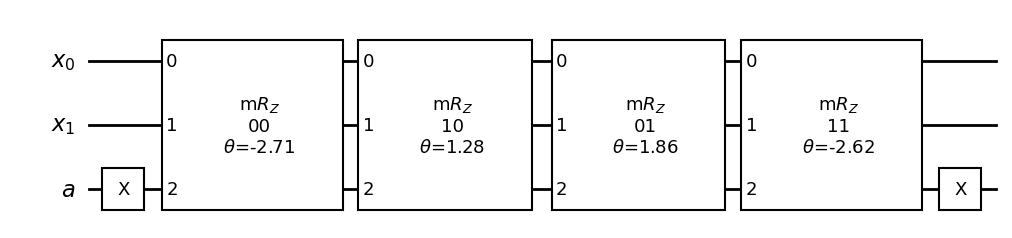

In [181]:
n = 2
args = np.random.uniform(-np.pi, np.pi, 1<<n)
qx = QuantumRegister(n, name='x')
qa = AncillaRegister(1, name='a')
qsp = QuantumCircuit(qx, qa)
qsp.compose(q_arg_prep(n, args), inplace=True)
print(args)
qsp.decompose().draw(output='mpl', style='bw')

In [163]:
def gen_psi (n):
    rand_amps = np.random.uniform(0, 10, 1<<n)
    rand_args = np.random.uniform(-np.pi, np.pi, 1<<n)
    rand_psi = rand_amps*np.exp(1.j*rand_args)
    norm_psi = np.linalg.norm(rand_psi)
    if norm_psi != 0:
        return (1/norm_psi)*rand_psi
    return gen_psi(n)

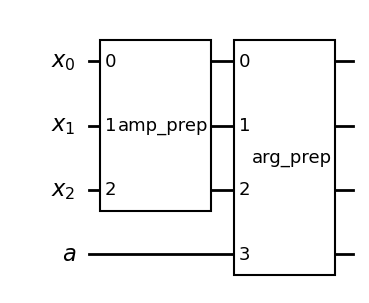

In [176]:
n = 3
psi = gen_psi(n)
psi_amps = np.absolute(psi)
psi_args = np.angle(psi)
qx = QuantumRegister(n, name='x')
qa = AncillaRegister(1, name='a')
qsp = QuantumCircuit(qx, qa, name='QSP')
angs = amp_to_ang(psi_amps)
qsp.compose(q_amp_prep(n, angs), qubits=qx, inplace=True)
qsp.compose(q_arg_prep(n, psi_args), inplace=True)
qsp.draw(output='mpl', style='bw')

In [177]:
psi

array([ 0.32739753+0.17486389j,  0.22528207+0.41682708j,
        0.36683523+0.04634891j, -0.02085329-0.04804081j,
       -0.20273178-0.45912j   , -0.08675452+0.46589596j,
       -0.03076956-0.01918843j, -0.14147502+0.02169516j])

In [178]:
Statevector(qsp).draw("latex")

<IPython.core.display.Latex object>